# 如何計算股票分割的原始價格

> 寫一些 R 程式計算 TSLA 與 AAPL 的未調整價格。
>
> 標籤：程式設計，獲取載入，整併轉換，摘要探索

郭耀仁 <yaojenkuo@datainpoint.com>

In [1]:
# 載入專案需要使用的套件
library(quantmod)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Version 0.4-0 included new data defaults. See ?getSymbols.



## TL; DR

在這個專案，我們打算寫一些 R 程式將特斯拉（美股代號：TSLA）與蘋果電腦（美股代號：AAPL）還原成未調整價格並繪製圖形觀察，將會使用 R 的 `quantmod` 作為資料擷取與操作的主要套件。

## 取得 TSLA 與 AAPL 歷史股價資料

使用 `quantmod` 套件的 `getSymbols()` 函式可以取得特斯拉（美股代號：TSLA）與蘋果電腦（美股代號：AAPL）的歷史股價資料。

In [2]:
start_date <- "1970-01-01"
getSymbols(Symbols = "TSLA", from = start_date) # create a xts object in global environment
getSymbols(Symbols = "AAPL", from = start_date) # create a xts object in global environment

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




[1] "TSLA"

Warning message:
“AAPL contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”


[1] "AAPL"

讀入蘋果電腦的歷史股價資料時，由於其中有遺漏值所以得到了警告訊息，可以使用 `is.na()` 搭配 `sum()` 函式判斷遺漏值筆數，並以 `na.omit()` 函式將資料有遺漏的觀測值移除。

In [3]:
sum(is.na(AAPL))      # check number of missing values
AAPL <- na.omit(AAPL) # removing missing values
sum(is.na(AAPL))      # check number of missing values after removal

[1] 6

[1] 0

TSLA 與 AAPL 這兩個物件都是 `xts` 類別，這是一種結合日期資訊與矩陣的類別，可以參考[如何使用 R 的時間序列 xts 類別](https://medium.com/datainpoint/what-is-r-xts-3ff16e7593fb?source=friends_link&sk=345abf2d2b4a03c44d363dab509561fa)。

In [4]:
class(TSLA)
class(AAPL)

[1] "xts" "zoo"

[1] "xts" "zoo"

股票分割完成以後，金融資訊網站（例如 Yahoo! Finance）將會依據分割比例對股票的歷史價格一併調整，原因是股價為量化交易中的重要訊號，若不對歷史價格作調整，容易造成投資人的誤判。

這一點從特斯拉與蘋果電腦的歷史股價圖形就可以發現到，從價格趨勢圖我們是看不出在哪些時間有發生過股票分割。

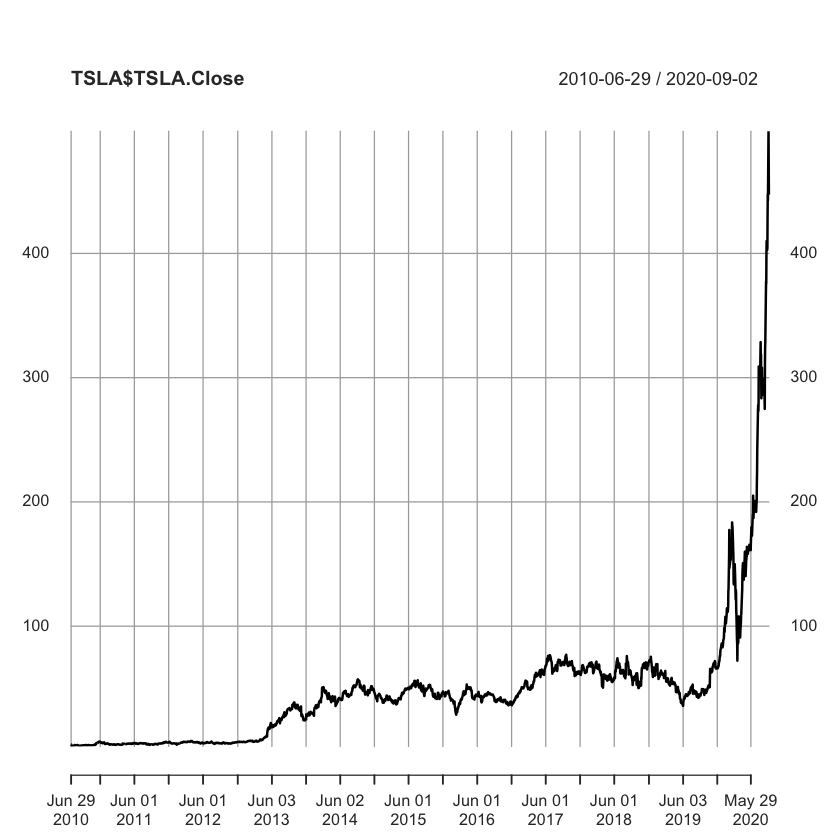

In [5]:
plot(TSLA$TSLA.Close)

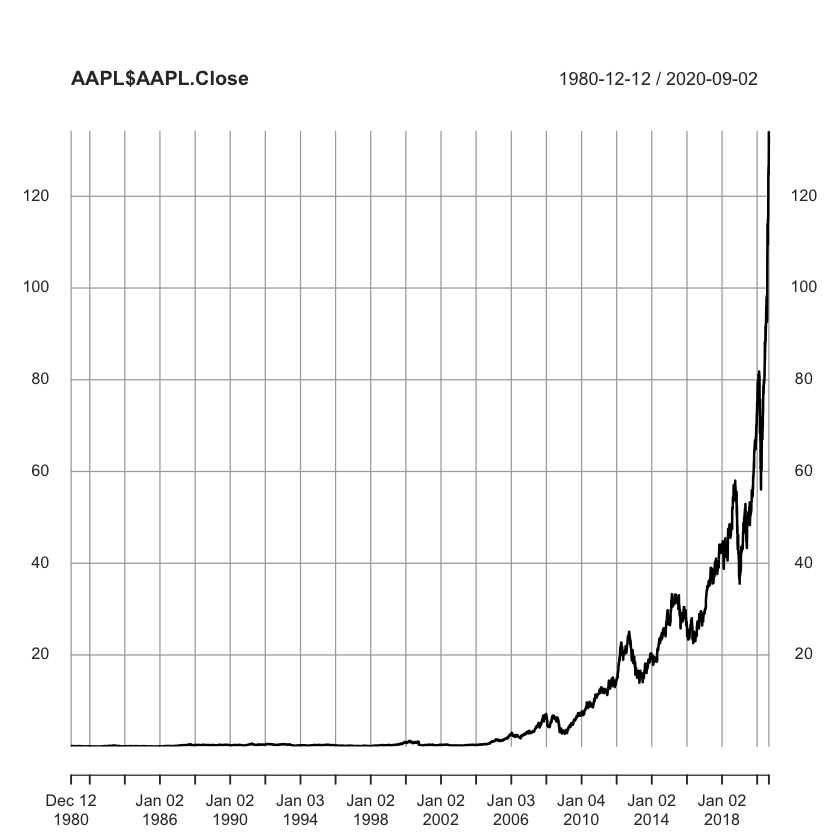

In [6]:
plot(AAPL$AAPL.Close)

## 取得 TSLA 與 AAPL 股票分割資訊

使用 `quantmod` 套件的 `getSplits()` 函式可以取得特斯拉（美股代號：TSLA）與蘋果電腦（美股代號：AAPL）的股票分割日期以及分割比例。

In [7]:
tsla_splits <- getSplits("TSLA")
aapl_splits <- getSplits("AAPL")

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=0&period2=1599091200&interval=1d&events=split&crumb=dtM8IxHZctk'”


特斯拉在公開上市以來第一度於 2020-08-31 完成股票 1 比 5 的分割。

In [8]:
tsla_splits

           TSLA.spl
2020-08-31      0.2

蘋果電腦在公開上市以來完成五度股票分割。

1. 1987-06-16 完成了股票 1 比 2 的分割；
2. 2000-06-21 完成了股票 1 比 2 的分割；
3. 2005-02-28 完成了股票 1 比 2 的分割；
4. 2014-06-09 完成了股票 1 比 7 的分割；
5. 2020-08-31 完成了股票 1 比 4 的分割。

In [9]:
aapl_splits

            AAPL.spl
1987-06-16 0.5000000
2000-06-21 0.5000000
2005-02-28 0.5000000
2014-06-09 0.1428571
2020-08-31 0.2500000

## 還原特斯拉股票原始價格

特斯拉公開上市以來只有在 2020-08-31 進行過一次股票分割，在判斷日期與還原價格的邏輯比較簡單。

In [10]:
# Extract split dates and ratios
tsla_split_dates <- index(tsla_splits)
tsla_split_ratios <- as.vector(coredata(tsla_splits))
# Reverse original stock price before split dates
tsla_before_split_dates <- sprintf('/%s', tsla_split_dates - 1)
tsla_after_split_dates <- sprintf('%s/', tsla_split_dates)
tsla_original <- TSLA[tsla_before_split_dates]$TSLA.Close / tsla_split_ratios
tsla_original <- rbind.xts(tsla_original, TSLA[tsla_after_split_dates]$TSLA.Close)
tail(tsla_original, n = 10)

           TSLA.Close
2020-08-20    2001.83
2020-08-21    2049.98
2020-08-24    2014.20
2020-08-25    2023.34
2020-08-26    2153.17
2020-08-27    2238.75
2020-08-28    2213.40
2020-08-31     498.32
2020-09-01     475.05
2020-09-02     447.37

從還原後的價格趨勢圖我們可以很明顯看出 TSLA 在 2020-08-31 有發生過因為股票分割導致股票價格大幅下跌的現象。

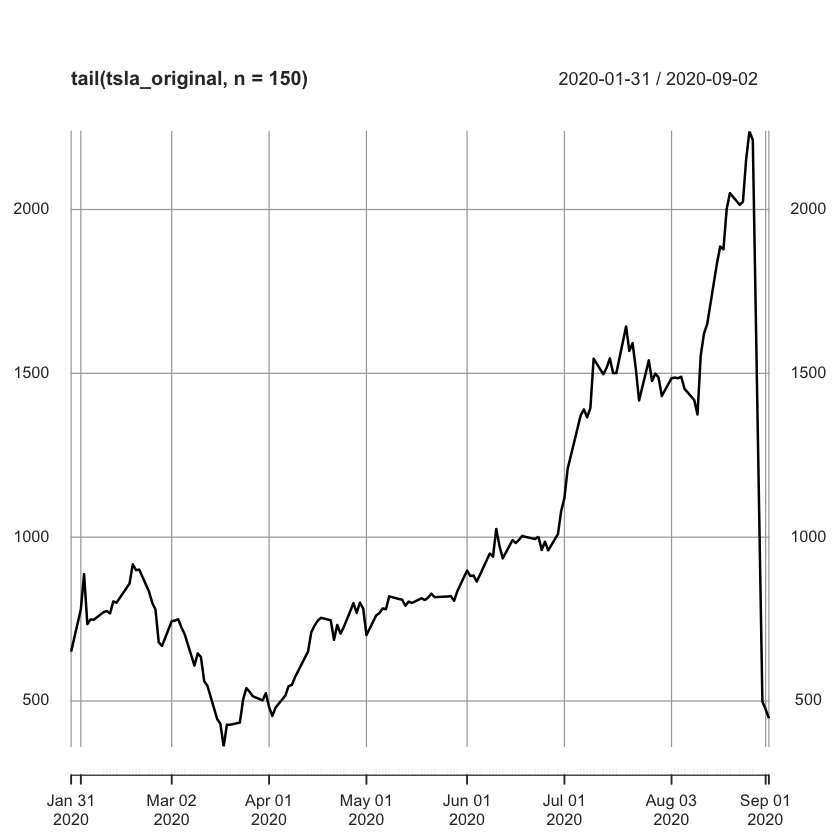

In [11]:
plot(tail(tsla_original, n = 150)) # plot recent 150 days of close prices

## 計算蘋果電腦股票原始價格

蘋果電腦公開上市以來進行過五次股票分割，在判斷日期與還原價格的邏輯比較複雜，我們特別寫了兩個函式：

1. `get_split_date_periods(split_dates)` 函式能夠在給定股票分割日期之下回傳符合 `xts` 類別能接受的日期區間；
2. `get_actual_historic_prices(adjusted_prices, split_date_periods, split_ratios)` 函式能夠在給定調整後價格、日期區間與分割比例之下回傳原始價格。

In [12]:
get_split_date_periods <- function(split_dates) {
  n_splits <- length(split_dates)
  if (n_splits > 1) {
    split_date_periods <- list()
    iterable <- c(1, 1:n_splits)
    for (i in 1:length(iterable)) {
      if (i == 1) {
        split_date_periods[[i]] <- sprintf("/%s", split_dates[iterable[i]] - 1)
      } else if (i == length(iterable)) {
        split_date_periods[[i]] <- sprintf("%s/", split_dates[iterable[i]])
      } else {
        split_date_periods[[i]] <- sprintf("%s/%s", split_dates[iterable[i]], split_dates[iterable[i + 1]] - 1)
      }
    }
    return(split_date_periods)
  } else if (n_splits == 1) {
    split_date_periods <- list()
    split_date_periods[[1]] <- sprintf("/%s", split_dates - 1)
    split_date_periods[[2]] <- sprintf("%s/", split_dates)
    return(split_date_periods)
  } else {
    message("No split date periods.")
  }
}
get_actual_historic_prices <- function(adjusted_prices, split_date_periods, split_ratios) {
  n_splits <- length(split_ratios)
  adjusted_prices_index <- index(adjusted_prices)
  actual_historic_prices <- c()
  for (i in n_splits:1) {
    original_prices <- adjusted_prices[split_date_periods[[i]]] / prod(split_ratios[n_splits:i])
    original_prices_values <- as.vector(coredata(original_prices))
    actual_historic_prices <- c(actual_historic_prices, rev(original_prices))
  }
  latest_adjusted_prices <- as.vector(coredata(adjusted_prices[split_date_periods[[n_splits + 1]]]))
  actual_historic_prices <- c(rev(latest_adjusted_prices), actual_historic_prices)
  actual_historic_xts <- xts(rev(actual_historic_prices), order.by = adjusted_prices_index)
  colnames(actual_historic_xts) <- 'AAPL.Close'
  return(actual_historic_xts)
}

首先我們給定蘋果電腦的五個股票分割日期，呼叫 `get_split_date_periods()` 函式，得到六個日期區間。

In [13]:
aapl_split_dates <- index(aapl_splits)   # Extract split dates
aapl_split_date_periods <- get_split_date_periods(aapl_split_dates) # Call function
aapl_split_date_periods

[[1]]
[1] "/1987-06-15"

[[2]]
[1] "1987-06-16/2000-06-20"

[[3]]
[1] "2000-06-21/2005-02-27"

[[4]]
[1] "2005-02-28/2014-06-08"

[[5]]
[1] "2014-06-09/2020-08-30"

[[6]]
[1] "2020-08-31/"

接著我們給定蘋果電腦的調整後價格、日期區間與分割比例，呼叫 `get_actual_historic_prices()` 函式，得到原始價格。

In [14]:
# Extract split ratio and adjusted prices
aapl_split_ratios <- as.vector(coredata(aapl_splits))
aapl_adjusted_prices <- AAPL$AAPL.Close
# Call function
aapl_original <- get_actual_historic_prices(aapl_adjusted_prices, aapl_split_date_periods, aapl_split_ratios)
tail(aapl_original, n = 10)

           AAPL.Close
2020-08-20     473.10
2020-08-21     497.48
2020-08-24     503.43
2020-08-25     499.30
2020-08-26     506.09
2020-08-27     500.04
2020-08-28     499.23
2020-08-31     129.04
2020-09-01     134.18
2020-09-02     131.40

從還原後的價格趨勢圖我們可以很明顯看出 AAPL 在 1987-06-16、2000-06-21、2005-02-28、2014-06-09 以及 2020-08-31 有發生過因為股票分割導致股票價格大幅下跌的現象。

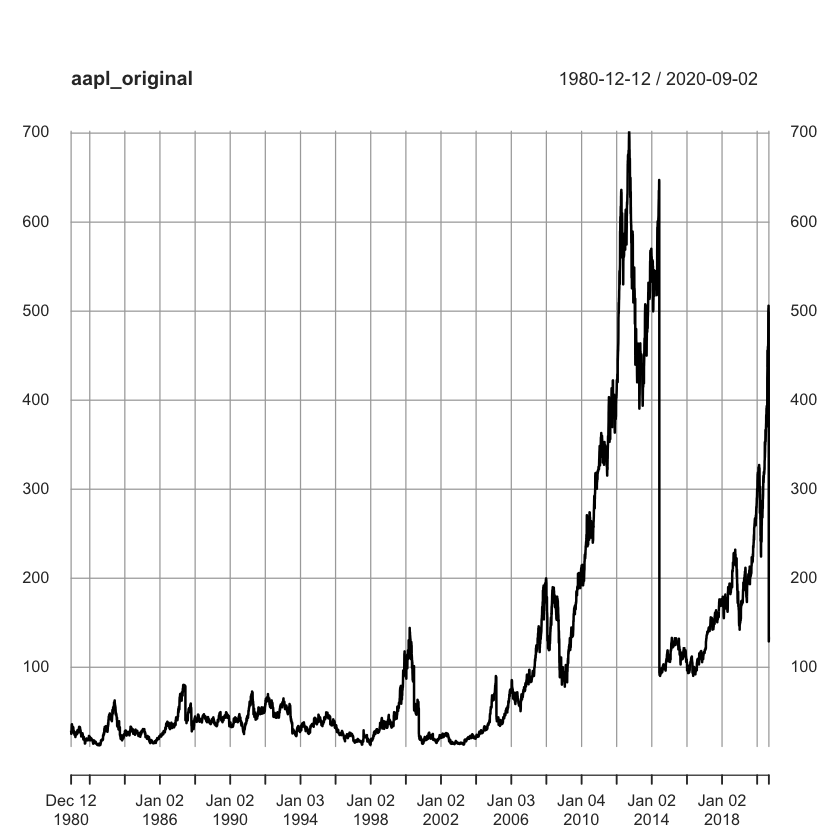

In [15]:
plot(aapl_original)